### Second Notebook: Data Cleaning & Preprocessing (Sprint 1 - Continued)

In [1]:
# Imports and Setup
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

data_path = os.path.join(os.getcwd(), '..', 'data')
out_path = os.path.join(os.getcwd(), '..', 'outputs')     # For the output

# Read the files
train = pd.read_csv(os.path.join(data_path, 'train.csv'))
test = pd.read_csv(os.path.join(data_path, 'test.csv'))
labels = pd.read_csv(os.path.join(data_path, 'train_labels.csv'))

# Merge training labels
df = pd.merge(train, labels, on='id')
print('Files successfully loaded and merged!')


Files successfully loaded and merged!


### ---------------------------------------------
### 🚧 Step 1: Handle Missing & Invalid Values
### ---------------------------------------------

In [2]:
# Replace 0s with NaN where 0 means "missing" or invalid

df['construction_year'] = df['construction_year'].replace(0, np.nan)
df['gps_height'] = df['gps_height'].replace([0, -90], np.nan)
df['longitude'] = df['longitude'].replace(0, np.nan)
print("Missing values after cleaning invalid numeric entries:")
print(df[['construction_year', 'gps_height', 'longitude']].isnull().sum())



Missing values after cleaning invalid numeric entries:
construction_year    20709
gps_height           20439
longitude             1812
dtype: int64


### ---------------------------------------------
### 🔧 Step 2: Construction Year Imputation
### ---------------------------------------------

In [3]:
# Save original missing count
missing_before = df['construction_year'].isna().sum()
print("Missing construction_year before Imputation:", missing_before)
mbr = df[['construction_year','region']] # missing before, with region
mbr['missing'] = mbr['construction_year'].isna()
mbr.groupby('region').sum()

Missing construction_year before Imputation: 20709


/tmp/ipykernel_28645/269173938.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mbr['missing'] = mbr['construction_year'].isna()


,construction_year,missing
region,,
Arusha,6594069.0,51
Dar es Salaam,1576820.0,17
Dodoma,0.0,2201
Iringa,9831406.0,372
Kagera,0.0,3316
Kigoma,5606470.0,10
Kilimanjaro,8672984.0,35
Lindi,2858609.0,113
Manyara,3143319.0,13


In [4]:
# Running through this again, with the regional differences in mind
reglist = ('Dodoma','Kagera','Mbeya','Mwanza','Shinyanga','Tabora') # regions often missing pumps
subdf = df[df['region'].isin(reglist)]
print(df['construction_year'].describe().T, subdf['construction_year'].describe().T)

count    38691.000000
mean      1996.814686
std         12.472045
min       1960.000000
25%       1987.000000
50%       2000.000000
75%       2008.000000
max       2013.000000
Name: construction_year, dtype: float64 count     519.000000
mean     1996.759152
std        10.620234
min      1963.000000
25%      1992.000000
50%      1998.000000
75%      2006.000000
max      2012.000000
Name: construction_year, dtype: float64


In [5]:
# Pumps in the same region likely have similar construction years, and seem to be missing at random
# Same funder or installer may follow same timeline
# Fill missing years with the median by region + installer
# If construction_year is missing, we could use date_recorded.year as an upper bound for imputation.
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df['recorded_year'] = df['date_recorded'].dt.year

subdf['date_recorded'] = pd.to_datetime(subdf['date_recorded'])
subdf['recorded_year'] = subdf['date_recorded'].dt.year


/tmp/ipykernel_28645/736104530.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['date_recorded'] = pd.to_datetime(subdf['date_recorded'])
/tmp/ipykernel_28645/736104530.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['recorded_year'] = subdf['date_recorded'].dt.year


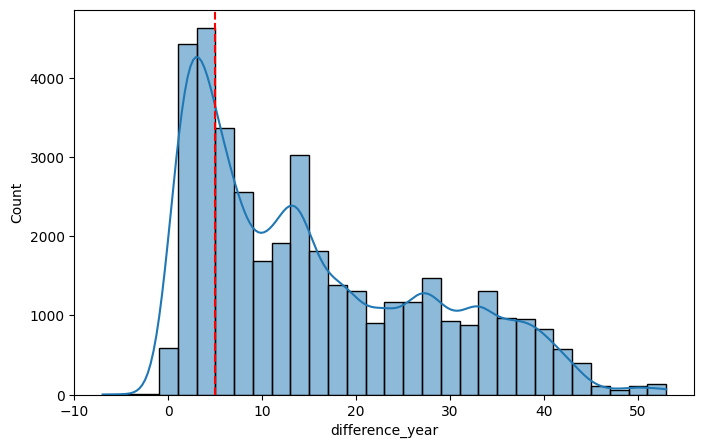

In [6]:
#visualize the relationship between construction_year and date_recorded to see how they are related
valid_years = df[df['construction_year'].notna()].copy()
valid_years['difference_year'] = valid_years['recorded_year']-valid_years['construction_year']

plt.figure(figsize=(8, 5))
sns.histplot(valid_years['difference_year'], bins=30, kde=True)
plt.axvline(5, color='red', linestyle='--', label='5-Year Gap')
plt.show()


### Small note:
I poked around with the missing data for construction year, and it looks like it's more spread than was suggested. But it also seems to roughly follow a skewed distribution,  so I would use 13 as the value for imputation, rather than the mode (5).

In [7]:
#Impute using region + installer
df['construction_year'] = df.groupby(['region', 'installer'])['construction_year'].transform(
    lambda x: x.fillna(x.median())
)
#Impute using region only (for rows still missing)
df['construction_year'] = df.groupby('region')['construction_year'].transform(
    lambda x: x.fillna(x.median())
)
#Use recorded year - 5
df['construction_year'] = df['construction_year'].fillna(df['recorded_year'] - 13)
missing_after = df['construction_year'].isna().sum()
print("Missing after_construction_year:", missing_after)
filled_count = missing_before - missing_after
print("Filled_construction_year:", filled_count)
df.to_csv(os.path.join(data_path, "cleaned_data_filled.csv"), index=False)


Missing after_construction_year: 0
Filled_construction_year: 20709


### ---------------------------------------------
### 🌍 Step 3: Fill Coordinates and Elevation
### ---------------------------------------------

In [8]:
# Handle GPS coordinates
print(df['longitude'].describe())
print("latitudeb and longitude missing value before:", df[['latitude', 'longitude']].isnull().sum())

# Convert to numeric in case of weird types
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# Drop invalid latitudes: outside Tanzania range or near zero
df['latitude'] = df['latitude'].apply(lambda x: np.nan if pd.isna(x) or abs(x) < 0.1 or x < -15 or x > 0 else x)
df['longitude'] = df['longitude'].apply(lambda x: np.nan if pd.isna(x) or abs(x) < 10 or x < 29 or x > 42 else x)

# Drop rows where lat/lon still missing
# df = df.dropna(subset=['latitude', 'longitude'])
# print("Remaining rows after dropping invalid GPS data:", len(df))

## Edited after sprint 2 to keep and impute values based on lga, then region

df['latitude'] = df['latitude'].where(df['latitude'] < -0.5, np.nan) # too close to the equator
for i in ['latitude','longitude']:
    df[i] = df.groupby('lga')[i].transform(lambda x: x.fillna(x.median))
    df[i] = df.groupby('region')[i].transform(lambda x: x.fillna(x.median))
df.longitude = pd.to_numeric(df.longitude, errors='coerce')
df.latitude = pd.to_numeric(df.latitude, errors='coerce') 

# Save updated version
df.to_csv(os.path.join(data_path,"cleaned_data_filled_V2.csv"), index=False)
print("Cleaned data saved to data/cleaned_data_filled_V2.csv")



count    57588.000000
mean        35.149669
std          2.607428
min         29.607122
25%         33.285100
50%         35.005943
75%         37.233712
max         40.345193
Name: longitude, dtype: float64
latitudeb and longitude missing value before: latitude        0
longitude    1812
dtype: int64


/tmp/ipykernel_28645/893939916.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[i] = df.groupby('region')[i].transform(lambda x: x.fillna(x.median))
/tmp/ipykernel_28645/893939916.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[i] = df.groupby('region')[i].transform(lambda x: x.fillna(x.median))


Cleaned data saved to data/cleaned_data_filled_V2.csv


In [9]:
# filling missing values for gps_height
# Replace invalid gps_height values (e.g. 0 or negative)
df['gps_height'] = df['gps_height'].apply(lambda x: np.nan if x <= 0 else x)

missing_gps_before = df['gps_height'].isna().sum()
print("Missing before gps_height:", missing_gps_before)

# Fill using median per lga 
## changed to lga by james (for more granular data)
df['gps_height'] = df.groupby('lga')['gps_height'].transform(
    lambda x: x.fillna(x.median())
)
# Fill any still missing using region median
df['gps_height'] = df.groupby('region')['gps_height'].transform(
    lambda x: x.fillna(x.median())
)    
missing_gps_after = df['gps_height'].isna().sum()
print("Missing after gps_height:", missing_gps_after)
print("Filled gps_height:", missing_gps_before - missing_gps_after)
df.to_csv(os.path.join(data_path, "cleaned_data_filled_V3.csv"), index=False)
print("Saved updated dataset to data/cleaned_data_filled_V3.csv")



Missing before gps_height: 21934
Missing after gps_height: 12115
Filled gps_height: 9819
Saved updated dataset to data/cleaned_data_filled_V3.csv


### ---------------------------------------------
### 👥 Step 4: Population Cleaning
### ---------------------------------------------

count    59400.000000
mean         0.333443
std          0.386980
min          0.000000
25%          0.000000
50%          0.200000
75%          0.600000
max          1.000000
Name: population, dtype: float64

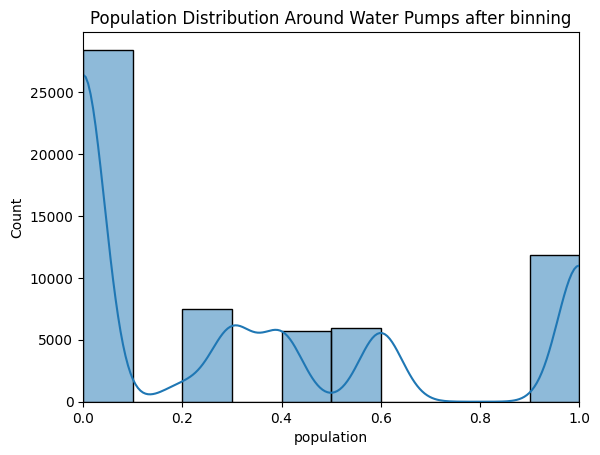

In [10]:
# filling population
## Replace 0 with NaN , not sure if 0 means 0 population os missing value
#df['population'] = df['population'].replace(0, np.nan)
#missing_pop_before = df['population'].isna().sum()

# Accepting 0 as valid, binning data 
#print("Missing population before:", missing_pop_before)

# Fill population using median by district_code
df['population'] = df.groupby('lga')['population'].transform(
    lambda x: x.fillna(x.median())
)
# Fill any still missing with median by region, then overall median
df['population'] = df.groupby('region')['population'].transform(
    lambda x: x.fillna(x.median())
)
df['population'] = df['population'].fillna(df.population.median)
# Bin the outcome, see how it behaves
df['population'] = pd.cut(df['population'], [-1,1,25,90,160,260,9999999], labels=[0,0.2,0.3,0.4,0.6,1])
df['population'] = df['population'].astype(float)

df.to_csv(os.path.join(data_path, "cleaned_data_filled_V4.csv"), index=False)

#sns.histplot(df['population'], bins=6, kde=True)
#plt.xlim(0, 10000)  # Focus on lower range
plt.title("Population Distribution Around Water Pumps")
#plt.savefig("outputs/population_distribution_before_clipping.png", dpi=300, bbox_inches='tight')
#plt.show()
#df['population'] = df['population'].clip(upper=1999)
sns.histplot(df['population'], bins=10, kde=True)
plt.xlim(0, 1)  # Reshaped
plt.title("Population Distribution Around Water Pumps after binning")
#plt.savefig("outputs/population_distribution_after_clipping.png", dpi=300, bbox_inches='tight')
df.to_csv(os.path.join(data_path, "cleaned_data_filled_V5.csv"))
df.population.describe()

### ---------------------------------------------
### Handelling Outliers
### ---------------------------------------------

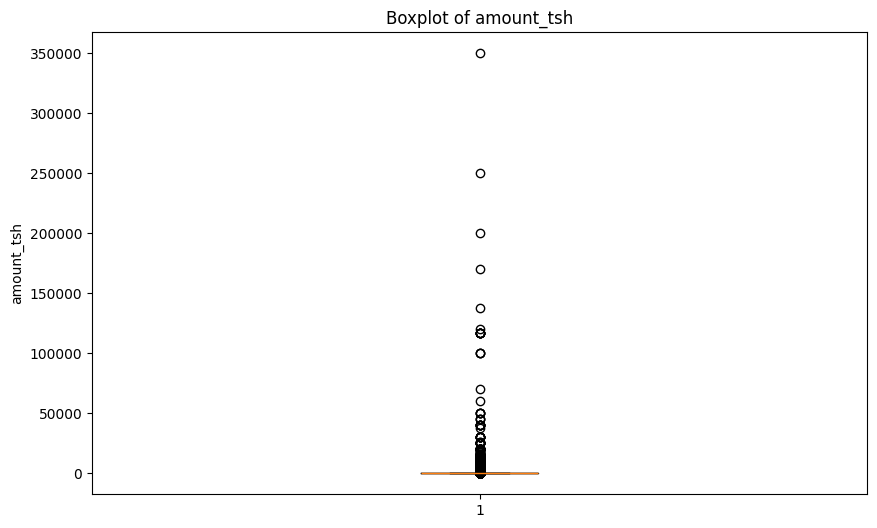

count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64

In [11]:
plt.figure(figsize=(10,6))
plt.boxplot(df['amount_tsh'])
plt.title('Boxplot of amount_tsh')
plt.ylabel('amount_tsh')
plt.show()
df.amount_tsh.describe().T

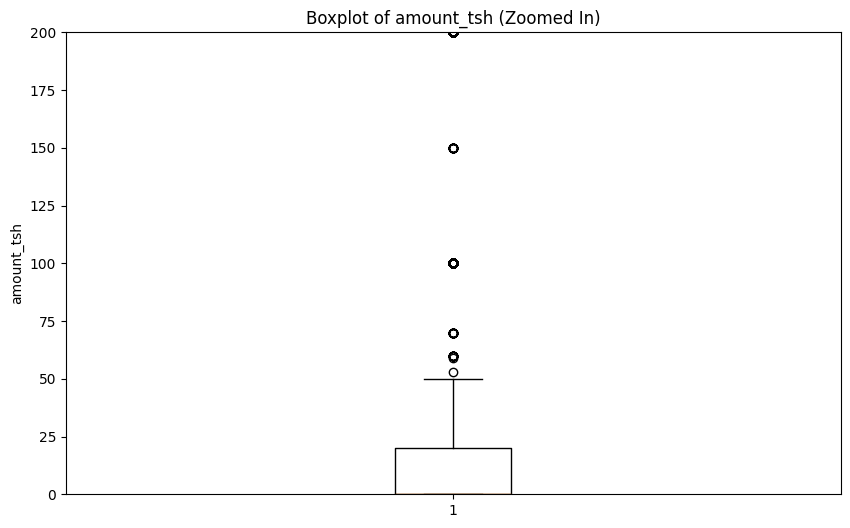

In [12]:
plt.figure(figsize=(10,6))
plt.boxplot(df['amount_tsh'].dropna())
plt.ylim(0, 200)  # Focus on the non-outlier range (up to 2,425 we calculated)
plt.title('Boxplot of amount_tsh (Zoomed In)')
plt.ylabel('amount_tsh')
plt.show()

### We want to check if amount_tsh is different for these status groups, This helps us see if amount_tsh is useful for predicting status.

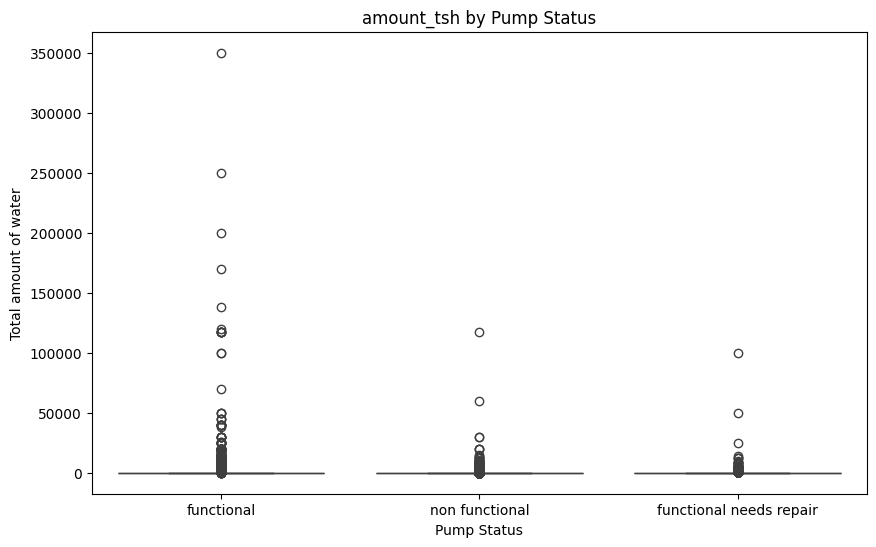

In [13]:
plt.figure(figsize=(10,6))
sns.boxplot(x='status_group', y='amount_tsh', data=df)

#plt.ylim(0,1500)
plt.title('amount_tsh by Pump Status')
plt.xlabel('Pump Status')
plt.ylabel('Total amount of water')
plt.show()

#### There are a lot of outliers (very big amount_tsh values) above 1500.
#### Those high values mostly belong to functional pumps.
#### So we cap the 'amount_tsh' at 150000.

In [14]:
#cap the 'amount_tsh' at 1500
df['amount_tsh_capped'] = df['amount_tsh'].apply(lambda x: min(x, 15000))

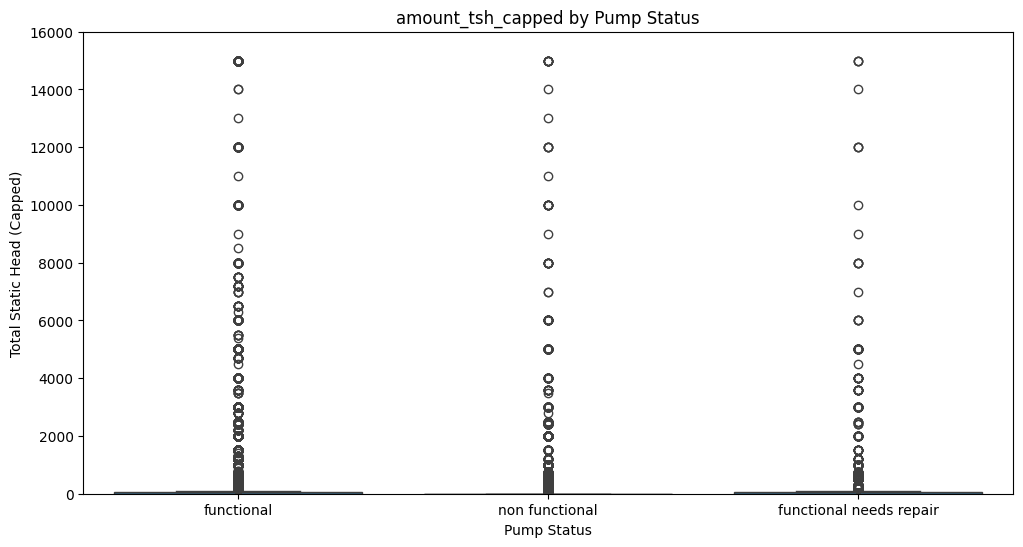

In [15]:
plt.figure(figsize=(12,6))
sns.boxplot(x='status_group', y='amount_tsh_capped', data=df)
plt.ylim(0, 16000)
plt.title('amount_tsh_capped by Pump Status')
plt.xlabel('Pump Status')
plt.ylabel('Total Static Head (Capped)')
plt.show()

In [16]:
df[df['status_group'] == 'non functional']['amount_tsh'].describe()

count     22824.000000
mean        123.481230
std        1110.120571
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      117000.000000
Name: amount_tsh, dtype: float64

#### Most of the non functional pumps have amount_tsh = 0 (confirmed). But there are a few very high values (like 117,000) in non functional.These could be errors (bad measurements),Or maybe something else is broken (e.g., mechanical damage, not water shortage).

In [26]:
    ### Encode categorical variables
# Encode 'quantity' (and typo fix: 'insufficent' -> 'insufficient')
df['quantity'] = df['quantity'].replace({
    'enough': 1,
    'seasonal': 0.6,
    'insufficient': 0.4,
    'dry': 0,
    'unknown': 0
})
df.quantity = pd.to_numeric(df.quantity, errors='coerce')

# Encode 'water_quality' as binary: good = 1, else 0
df['water_quality'] = np.where(df['water_quality'] == 'soft', 1, 0)
# Encode 'waterpoint_type' (1 = preferred type, 0 = everything else)
preferred_waterpoint = ['hand pump', 'communal standpipe']
df['waterpoint_type'] = df['waterpoint_type'].apply(lambda x: 1 if x in preferred_waterpoint else 0)
# Encode 'payment' as binary: never pay = 0, else = 1
df['payment'] = np.where(df['payment'] == 'never pay', 0, 1)
# Encode 'source' (1 = preferred sources, 0 = everything else)
preferred_sources = ['spring', 'river', 'rainwater harvesting']
df['source'] = df['source'].apply(lambda x: 1 if x in preferred_sources else 0)
# Encode 'payment' as binary: never pay = 0, else = 1
df['extraction_type_class'] = np.where(df['extraction_type_class'] == 'gravity', 0, 1)

df.to_csv(os.path.join(data_path, "cleaned_data_filled_V6.csv"), index=False)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['amount_tsh_scaled'] = scaler.fit_transform(df[['amount_tsh_capped']])



/tmp/ipykernel_28645/4125883173.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['quantity'] = df['quantity'].replace({


### ---------------------------------------------
### Encode Categorical Variables
### ---------------------------------------------

missing categorical values:
date_recorded                0
funder                    3637
installer                 3655
wpt_name                     2
basin                        0
subvillage                 371
region                       0
lga                          0
ward                         0
public_meeting            3334
recorded_by                  0
scheme_management         3878
scheme_name              28810
permit                    3056
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity_group               0
source                       0
source_type                  0
source_class                 0
waterpoint_type              0
waterpoint_type_group        0
status_group                 0
dtype: int6

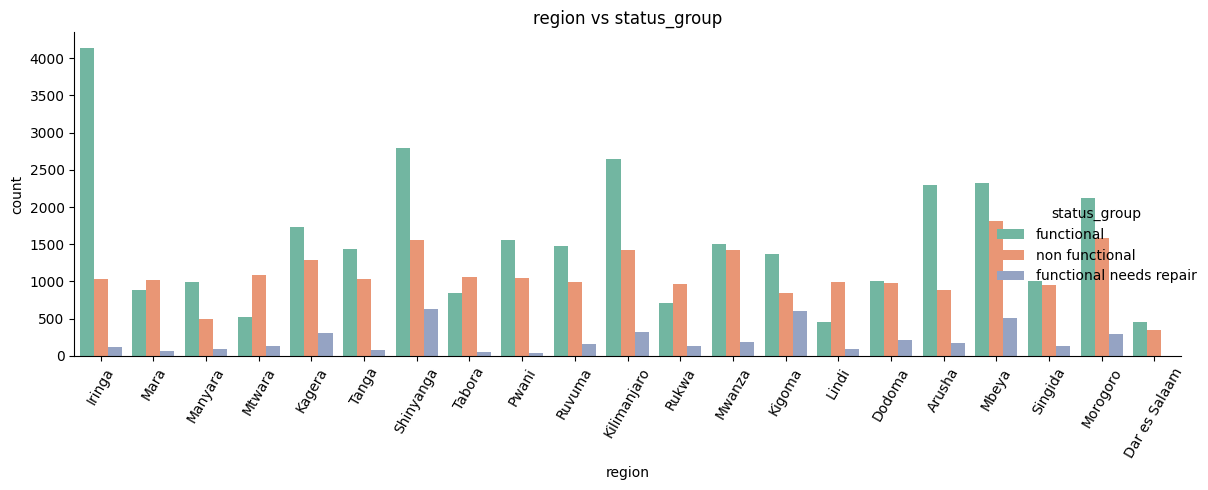

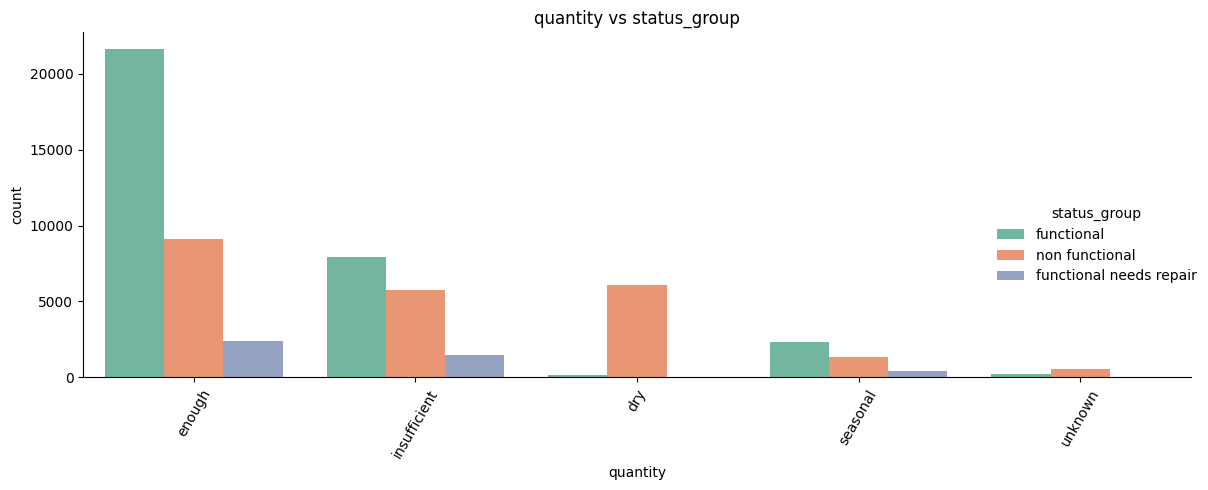

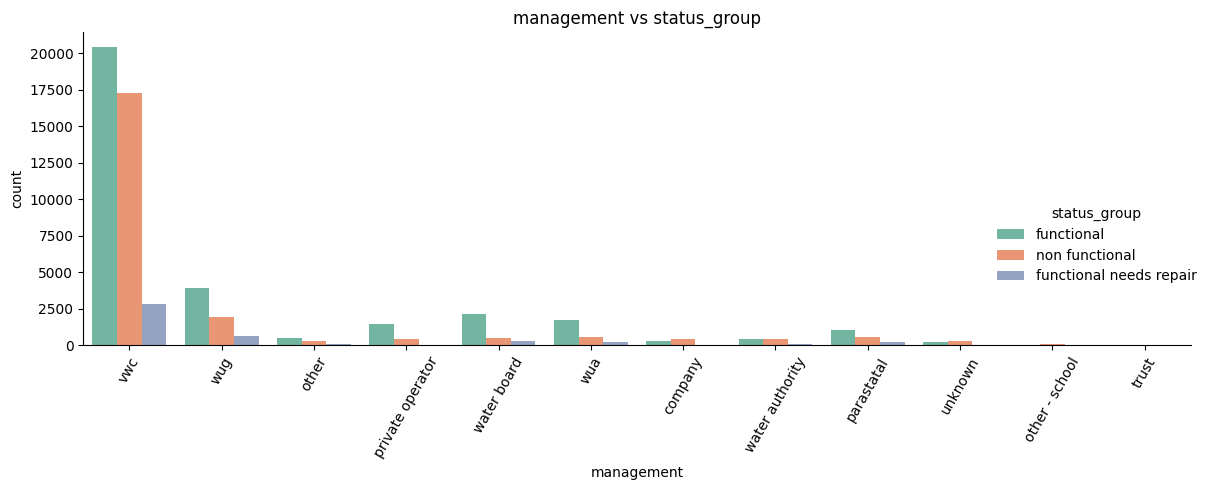

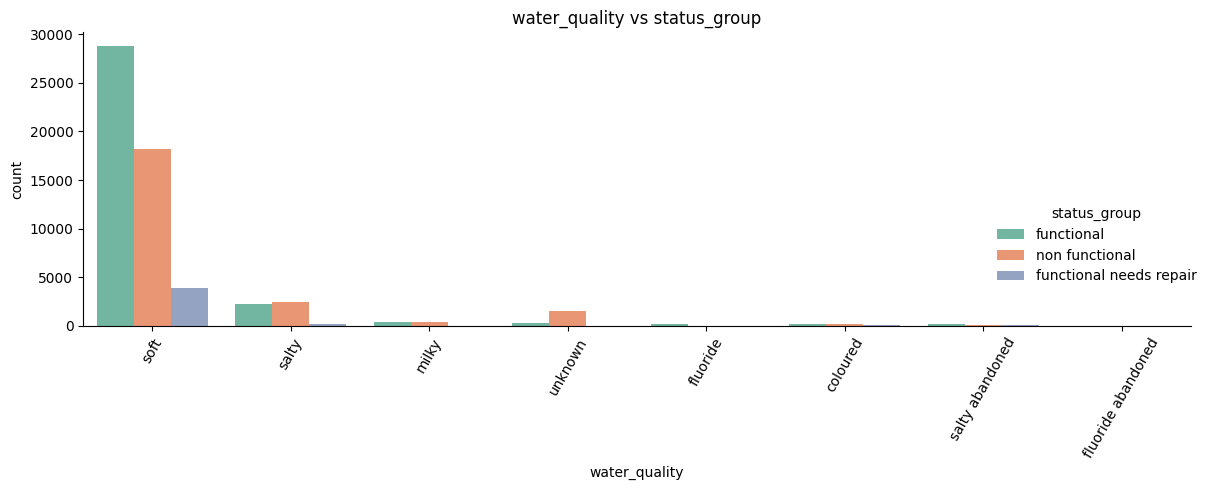

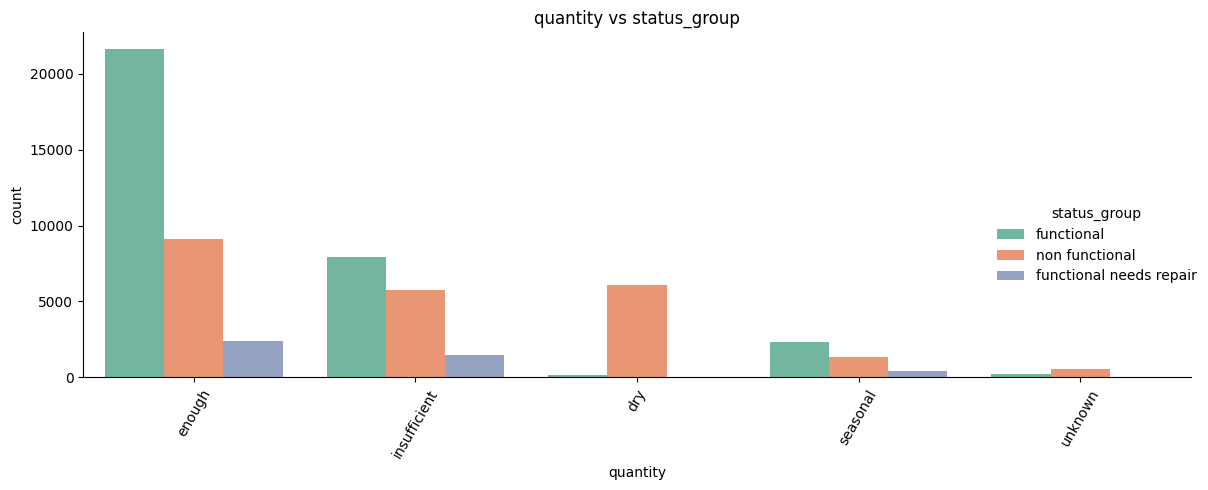

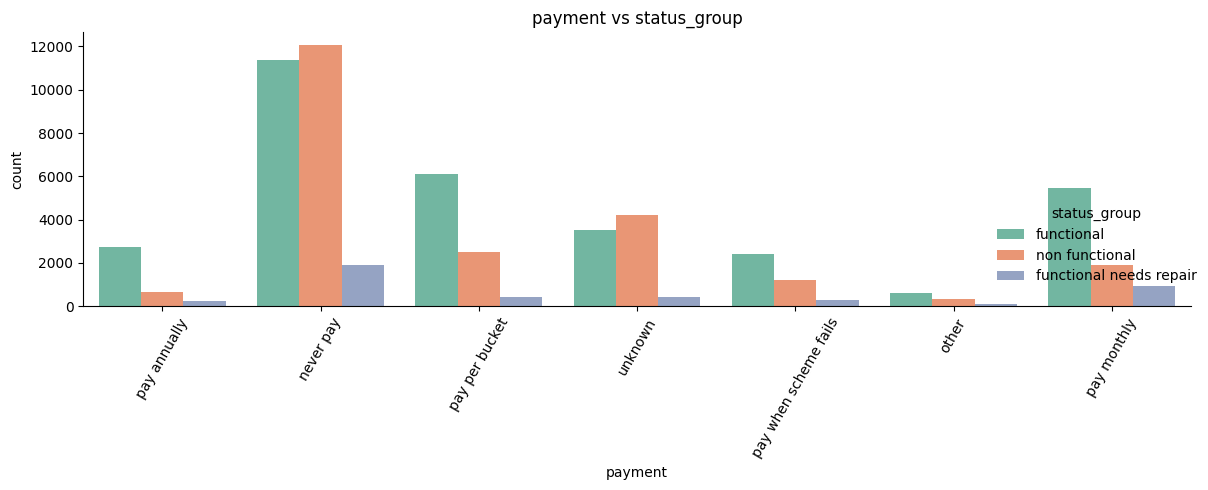

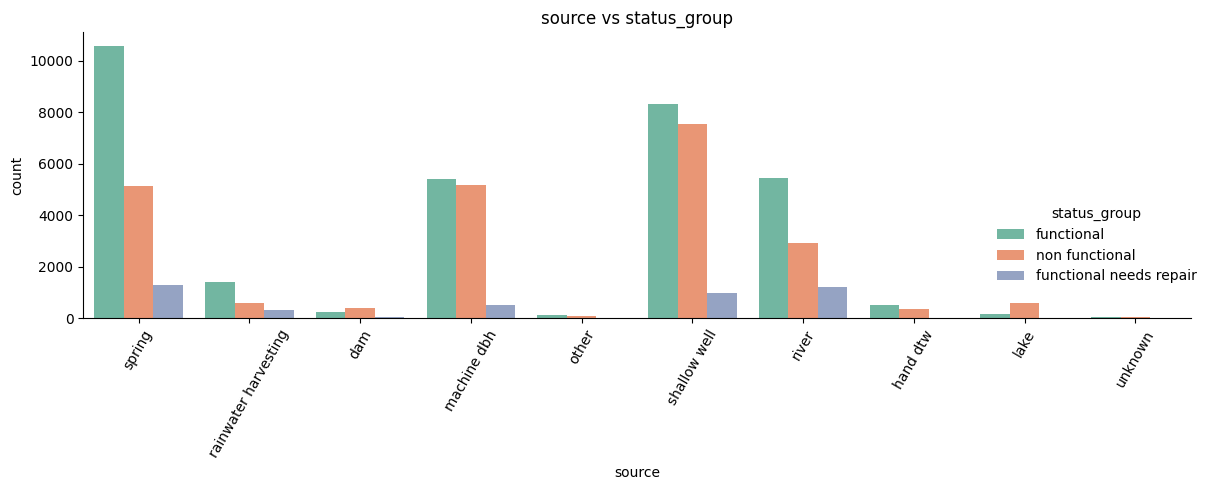

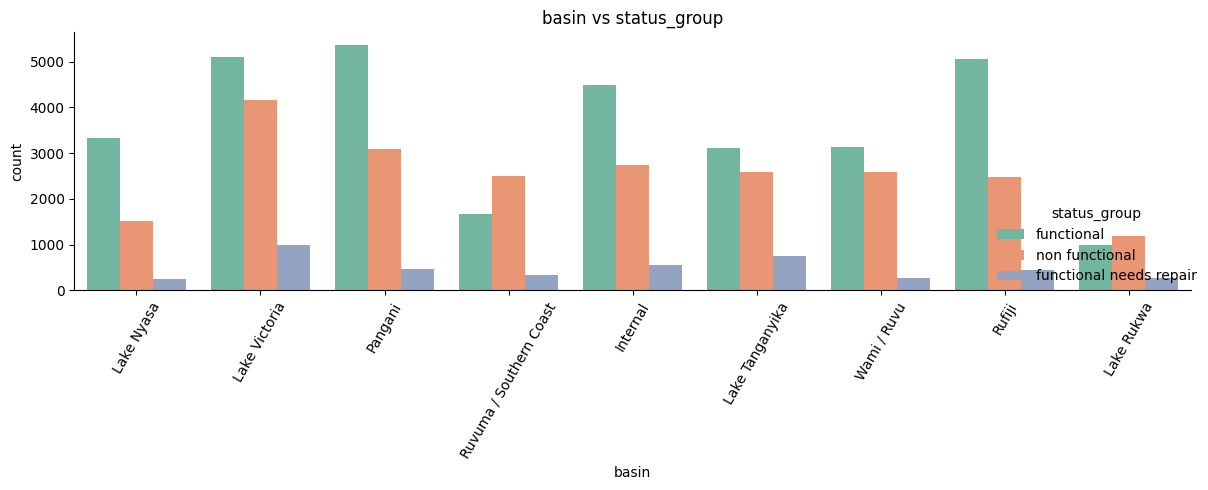

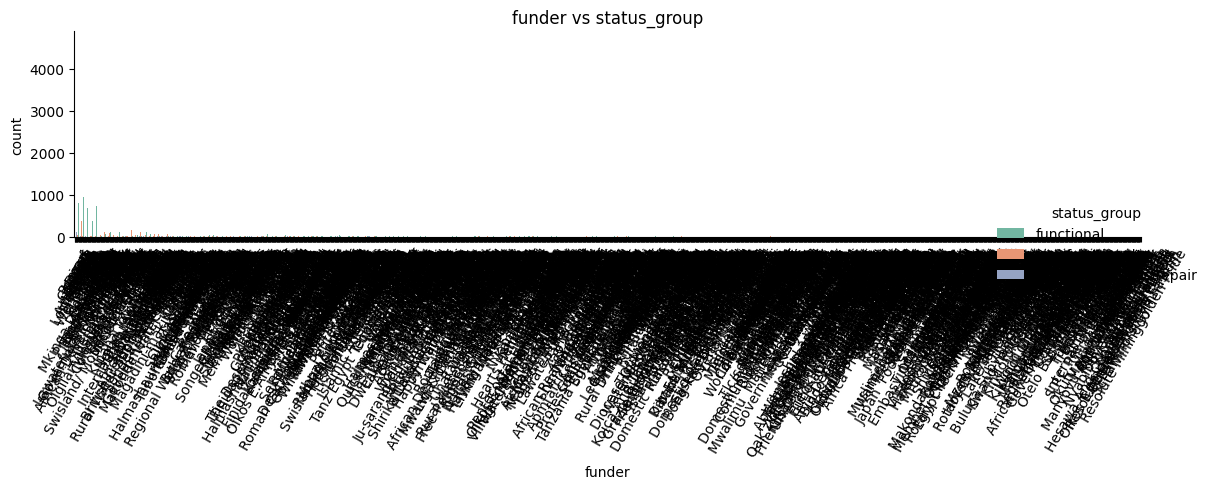

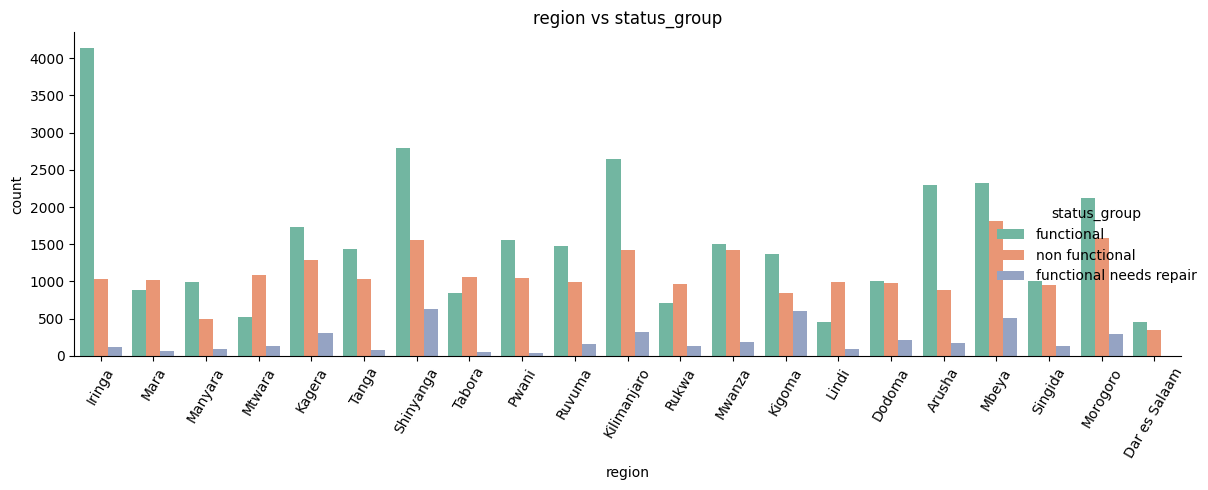

In [18]:
# Load cleaned data
df = pd.read_csv(os.path.join(data_path, 'cleaned_data_filled_V6.csv'))

# Fill missing categorical values with 'Unknown'
categorical_cols = df.select_dtypes(include='object').columns
missing_cat = df[categorical_cols].isnull().sum()
print('missing categorical values:')
print(missing_cat)
df[categorical_cols] =df[categorical_cols].fillna('Unknown')

# Selected categorical variable 
catvars = [
    'region','quantity','management','water_quality',
    'quantity','payment','source','basin', 'funder','region'
    
]


# Plot grouped bar plots colored by pump status
target = 'status_group'
for col in catvars:
    sns.catplot(x=col, kind='count', hue=target, data=df, height=5, aspect=2, palette='Set2')
    plt.xticks(rotation=60)
    plt.title(f"{col} vs {target}")
    plt.tight_layout()
    plt.show()

### Encoding for modeling prep

In [49]:

from sklearn.preprocessing import LabelEncoder

#  Drop high-cardinality columns
drop_cols = ['funder', 'installer', 'wpt_name', 'subvillage', 'scheme_name']
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in drop_cols and col != 'id' and col != target]

# One-hot encode medium-cardinality features (between 3 and 10 unique values)
onehot_cols = [col for col in categorical_cols if 2 < df[col].nunique() <= 10]
df_encoded = pd.get_dummies(df, columns=onehot_cols, drop_first=True)

#  Label encode low-cardinality features (<= 2 unique values)
label_enc_cols = [col for col in categorical_cols if df[col].nunique() <= 2]
label_encoders = {}
for col in label_enc_cols:
    le = LabelEncoder()
    df_encoded[col] = df_encoded[col].astype(str)
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

#  Save encoded dataset
df_encoded.to_csv(os.path.join(out_path, 'encoded_data_V1.csv'), index=False)

print("Categorical EDA and encoding complete.")


Categorical EDA and encoding complete.


In [116]:
# Load data
y = pd.read_csv(os.path.join(data_path, 'train_labels.csv'))
x_full = pd.read_csv(os.path.join(data_path, 'cleaned_data_filled_V6.csv'))

In [112]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Load data
y = pd.read_csv(os.path.join(data_path, 'train_labels.csv'))
df = pd.read_csv(os.path.join(data_path, 'cleaned_data_filled_V6.csv'))

# minor last-minute imputations
df['gps_height'] = df['gps_height'].apply(lambda x: np.nan if x <= 0 else x)
# Fill using median per basin
df['gps_height'] = df.groupby('basin')['gps_height'].transform(
    lambda x: x.fillna(x.median())
)

    
#location
df['longitude'] = df['longitude'].replace(0, np.nan,inplace=True)
df['latitude'] = df['latitude'].where(train['latitude'] < -0.5, np.nan,inplace=True) # too close to the equator
df['latitude'] = df.groupby('lga')['latitude'].transform(lambda x: x.fillna(x.median))
df['latitude'] = df.groupby('region')['latitude'].transform(lambda x: x.fillna(x.median))
df['longitude'] = df.groupby('lga')['longitude'].transform(lambda x: x.fillna(x.median))
df['longitude'] = df.groupby('region')['longitude'].transform(lambda x: x.fillna(x.median))
                              
#df['longitude'] = pd.to_numeric(df['longitude'], downcast='float')
#df['latitude'] = pd.to_numeric(df['latitude'], downcast='float') 

# longitude and latitude returning `object` variables, not float. Don't know why

# Drop status_group if present
df = df.drop(columns=['status_group'], errors='ignore')
df = pd.merge(y, df, on='id', how='inner')

from sklearn.preprocessing import StandardScaler

#  Choose  features
features = df[['amount_tsh',
             'gps_height',
#             'longitude',
#             'latitude',
             'population',
             'construction_year',
             'extraction_type_class',
             'payment',
            'water_quality',
            'quantity',
            'source',
            'waterpoint_type',
            'permit'
       ]]
x = df[['amount_tsh',
             'gps_height',
#             'longitude',
#             'latitude',
             'population',
             'construction_year',
             'extraction_type_class',
             'payment',
             'water_quality',
             'quantity',
             'source',
             'waterpoint_type',
             'permit'
       ]]

# Apply standard scaling (mean 0, std 1)
#scaler = StandardScaler()
#x_scaled = scaler.fit_transform(x)

#  Convert back to DataFrame (to keep column names)
#x = pd.DataFrame(x_scaled)

#  Prepare target
y = df['status_group'].astype('category').cat.codes

print(x.info())
# Shape check
print("X shape:", x.shape)
print("Y shape:", y.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   gps_height             59400 non-null  float64
 2   population             59400 non-null  float64
 3   construction_year      59400 non-null  float64
 4   extraction_type_class  59400 non-null  int64  
 5   payment                59400 non-null  int64  
 6   water_quality          59400 non-null  int64  
 7   quantity               59400 non-null  float64
 8   source                 59400 non-null  int64  
 9   waterpoint_type        59400 non-null  int64  
dtypes: float64(5), int64(5)
memory usage: 4.5 MB
None
X shape: (59400, 10)
Y shape: (59400,)


In [113]:
import statsmodels.api as sm
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
print(results.summary2())


                   Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     0.251      
Dependent Variable:   y                AIC:                145290.8062
Date:                 2025-05-27 20:55 BIC:                145389.7188
No. Observations:     59400            Log-Likelihood:     -72634.    
Df Model:             10               F-statistic:        1992.      
Df Residuals:         59389            Prob (F-statistic): 0.00       
R-squared:            0.251            Scale:              0.67564    
----------------------------------------------------------------------
                       Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                 32.1974   0.6880  46.7954 0.0000 30.8489 33.5460
amount_tsh            -0.0000   0.0000  -5.6808 0.0000 -0.0000 -0.0000
gps_height            -0.0001   0.0000  -8.0108 0.0000 -0.0001 -0.0000
population            -0.0

## We see that the basic regression considers all the quantitative variables statistically significant, but not having such a large effect, with the exception of construction year. This suggests that the analysis will rely on 

permit
True     38852
False    17492
Name: count, dtype: int64